#### GSS

1. (id_)       Respondent id number
2. (year)      GSS year for this respondent
3. (polviews)  Liberal or conservative
4. (letin1a)   Immigration should be increased or decreased
5. (racdif1)   differences due to discrimination
6. (racdif2)   differences due to in-born learning ability
7. (racdif3)   differences due to lack of education
8. (racdif4)   differences due to lack of will
9. (workwhts)  hard working - lazy
10. (workblks)  hard working - lazy
11. (workhsps)  hard working -lazy
12. (intlwhts)  unintelligent -intelligent
13. (intlblks)  unintelligent - intelligent
14. (intlhsps)  unintelligent - intelligent
15. (marwht)    r favor close relative marrying white person
16. (marblk)    close relative marry black
17. (marhisp)   close relative marry hispanic

In [1]:
from functools import reduce
from os.path import expanduser
import numpy as np
import pandas as pd
import pingouin as pg
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
def margin_of_error_proportion(r, n, ci=.95, method='asymp'):
    '''
    Calculate the margin of error for given proportion.
    
    Parameters
    ----------
    r : int
        Number of successes.
    n : int
        Number of trials.
    ci : float, optional
        Confidence interval.
    method : str, optional
        asymp = Simple asymptomatic.
        asymp_cc = Symple asymptomatic with continuity correction.
        score = Wilson score.
        score_cc = Wilson score with continuity correction.
        exact = Clopper-Pearson method.
    
    Returns
    -------
    me : float
        Margin of error.
        
    References
    ----------
    .. [1] https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/PASS/Confidence_Intervals_for_One_Proportion.pdf
    '''
    p = r/n
    if method == 'asymp':
        z = stats.norm(loc=0, scale=1).ppf((1-ci)/2)
        me = z * np.sqrt(p*(1-p)/n)
    elif method == 'asymp_cc':
        z = stats.norm(loc=0, scale=1).ppf((1-ci)/2)
        me = z * np.sqrt(p*(1-p)/n)+1/(2*n)
    return me

def two_proportions_z_test(x0, n0, x1, n1, pooled=True, cc=False):
    '''
    Calculate the Z statistic for two proportions.

    Parameters
    ----------
    x0 : int
        Number of successes for the first group.
    n0 : int
        Number of trials for the first group.
    x1 : int
        Number of successes for the second group.
    n1 : int
        Number of trials for the second group.
    null : float, optional
        The value of the null.
        By default it's assumed to be 0 (The proportions should be equal).
    pooled : boolean, optional
        Whether to estimate the standard error with the pooled (averaged) or unpooled proportions.
    cc : boolean, optional
        Whether to use Yate's continuity correction.

    Returns
    -------
    z : float
        The Z statistic.

    References
    ----------
    .. [1] https://www.statisticshowto.com/z-test/
    .. [2] https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/PASS/Tests_for_Two_Proportions.pdf
    .. [3] https://influentialpoints.com/Training/z-test_for_independent_proportions-principles-properties-assumptions.htm
    '''
    p0, p1 = x0/n0, x1/n1
    if pooled:
        p = (x0+x1)/(n0+n1)
        se = np.sqrt(p*(1-p)/n0 + p*(1-p)/n1)
    else:
        se = np.sqrt(p0*(1-p0)/n0 + p1*(1-p1)/n1)
    z = (((p1-p0) - (1/n0+1/n1)/2) if cc else (p1-p0)) / se
    return z

def parse_string(s, size):
    return reduce(lambda x, y: x+(' ' if len(x.split('\n')[-1]+y) < size else '\n')+y, s.split(' '))

### Load and visualize data for 2014-2022

In [58]:
df = pd.read_csv(expanduser('~') + '/Documents/Surveys/Justice workers/GSS justice workers 2014-2022.csv')
df['letin1a'] = df['letin1a'].map(
    lambda x: 'REDUCED' if x in ('Reduced a little', 'Reduced a lot') else\
              'NEITHER' if x == 'Remain the same as it is' else\
              'INCREASED' if x in ('Increased a little', 'Increased a lot') else x
)
df['workwhts'] = df['workwhts'].map(
    lambda x: 'HARDWORKING' if x in ('2', '3') else 'NEITHER' if x == '4' else 'LAZY' if x in ('5', '6') else x
)
df['workblks'] = df['workblks'].map(
    lambda x: 'HARDWORKING' if x in ('2', '3') else 'NEITHER' if x == '4' else 'LAZY' if x in ('5', '6') else x
)
df['workhsps'] = df['workhsps'].map(
    lambda x: 'HARDWORKING' if x in ('2', '3') else 'NEITHER' if x == '4' else 'LAZY' if x in ('5', '6') else x
)
df['intlwhts'] = df['intlwhts'].map(
    lambda x: 'UNINTELLIGENT' if x in ('2', '3') else 'NEITHER' if x == '4' else 'INTELLIGENT' if x in ('5', '6') else x
)
df['intlblks'] = df['intlblks'].map(
    lambda x: 'UNINTELLIGENT' if x in ('2', '3') else 'NEITHER' if x == '4' else 'INTELLIGENT' if x in ('5', '6') else x
)
df['intlhsps'] = df['intlhsps'].map(
    lambda x: 'UNINTELLIGENT' if x in ('2', '3') else 'NEITHER' if x == '4' else 'INTELLIGENT' if x in ('5', '6') else x
)
df['marwht'] = df['marwht'].map(
    lambda x: 'NEITHER' if 'NEITHER' in x else 'FAVOR' if 'FAVOR' in x else 'OPPOSE' if 'OPPOSE' in x else x
)
df['marblk'] = df['marblk'].map(
    lambda x: 'NEITHER' if 'NEITHER' in x else 'FAVOR' if 'FAVOR' in x else 'OPPOSE' if 'OPPOSE' in x else x
)
df['marhisp'] = df['marhisp'].map(
    lambda x: 'NEITHER' if 'NEITHER' in x else 'FAVOR' if 'FAVOR' in x else 'OPPOSE' if 'OPPOSE' in x else x
)
df.tail()

,year,id_,indus10,polviews,racdif1,racdif2,racdif3,racdif4,workwhts,workblks,workhsps,intlwhts,intlblks,intlhsps,marblk,marhisp,marwht,letin1a
15324,2018,772,Insurance carriers and related activities,Slightly conservative,YES,NO,YES,YES,NEITHER,98,HARDWORKING,INTELLIGENT,NEITHER,INTELLIGENT,FAVOR,FAVOR,FAVOR,INCREASED
15325,2018,773,Warehousing and storage,Conservative,YES,.d: Do not Know/Cannot Choose,YES,YES,NEITHER,NEITHER,NEITHER,NEITHER,NEITHER,UNINTELLIGENT,OPPOSE,OPPOSE,NEITHER,REDUCED
15326,2018,774,Restaurants and other food services,Conservative,YES,.d: Do not Know/Cannot Choose,NO,NO,NEITHER,LAZY,LAZY,UNINTELLIGENT,NEITHER,NEITHER,OPPOSE,OPPOSE,OPPOSE,NEITHER
15327,2018,775,Outpatient care centers,Extremely liberal,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable
15328,2018,776,"Drinking places, alcoholic beverages",Slightly liberal,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable


In [4]:
industries_justice = 'Justice, public order, and safety activities'
industries_invalid = ('.i: Inapplicable', '.n: No answer', '.s: Skipped on Web', '.u: Uncodable')

df_justice = df.loc[np.where([x == industries_justice for x in df['indus10']])]
df_justice.index = range(len(df_justice))
df_other = df.loc[np.where([x != industries_justice and x not in industries_invalid for x in df['indus10']])]
df_other.index = range(len(df_other))

df_justice.shape, df_other.shape

((278, 18), (15051, 18))

11 0.0399 22 0.0797 26 0.0942 96 0.3478 50 0.1812 65 0.2355 6 0.0217 
740 0.0508 2019 0.1386 1693 0.1162 5402 0.3709 1855 0.1274 2204 0.1513 653 0.0448 


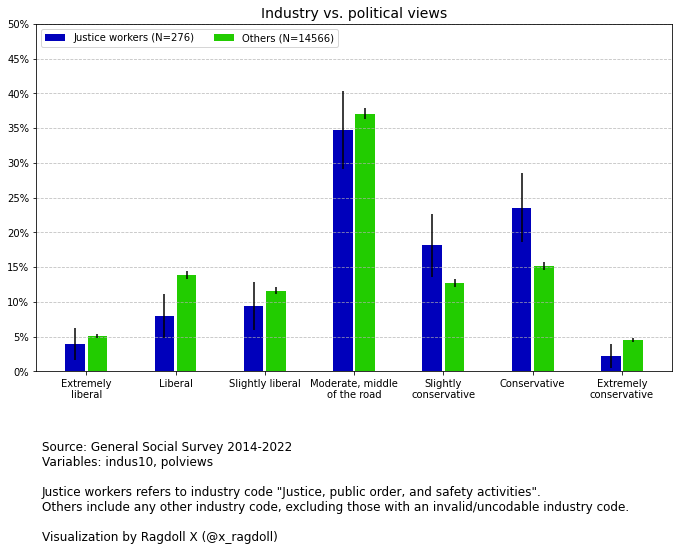

In [5]:
values = ('Extremely liberal', 'Liberal', 'Slightly liberal', 'Moderate, middle of the road', 'Slightly conservative', 'Conservative', 'Extremely conservative')
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['polviews'].map(lambda x: x in values)]['polviews']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        n = len(np.where(data == v)[0])
        me = margin_of_error_proportion(n, total)
        rect = ax.bar(i/4 + j - 1.125, n/total, width=.22, color=color, yerr=me)
        print(n, np.round(n/total, 4), end=' ')
    print()
    legend_handles.append(rect) # Only need the last one.
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .5)
ax.set_yticks(np.arange(0, .51, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 51, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=2, loc='upper left')
ax.set_title('Industry vs. political views', fontsize=14)
ax.text(
    x=-1.5, y=-.1, va='top', fontsize=12,
    s='Source: General Social Survey 2014-2022\nVariables: indus10, polviews\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable industry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig1.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

[ 59  96 121] [0.2138 0.3478 0.4384]
[4452 5402 4712] [0.3056 0.3709 0.3235]


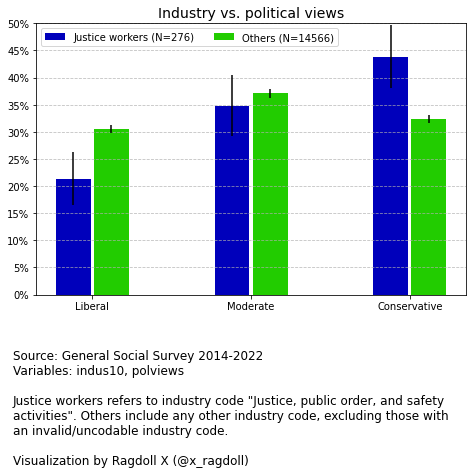

In [6]:
values = ('Extremely liberal', 'Liberal', 'Slightly liberal', 'Moderate, middle of the road', 'Slightly conservative', 'Conservative', 'Extremely conservative')
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['polviews'].map(lambda x: x in values)]['polviews']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    p = np.array([
        len(np.where([x in ('Extremely liberal', 'Liberal', 'Slightly liberal') for x in data])[0]),
        len(np.where([x in ('Moderate, middle of the road') for x in data])[0]),
        len(np.where([x in ('Extremely conservative', 'Conservative', 'Slightly conservative') for x in data])[0])
    ])
    print(p, np.round(p/total, 4))
    me = [margin_of_error_proportion(x, total) for x in p]
    rect = ax.bar(np.arange(-1, 2)+(-.12, .12)[i], p/total, width=.22, color=color, yerr=me)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, 2))
ax.set_xticklabels([parse_string(v, 16) for v in ('Liberal', 'Moderate', 'Conservative')])
ax.set_ylim(0, .5)
ax.set_yticks(np.arange(0, .51, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 51, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=2, loc='upper left')
ax.set_title('Industry vs. political views', fontsize=14)
ax.text(
    x=-1.5, y=-.1, va='top', fontsize=12,
    s=parse_string(
        'Source: General Social Survey 2014-2022\nVariables: indus10, polviews\n\n'+\
        'Justice workers refers to industry code "Justice, public order, and safety activities". '+\
        'Others include any other industry code, excluding those with an invalid/uncodable industry code.\n\n'+\
        'Visualization by Ragdoll X (@x_ragdoll)',
        75
    ),
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig2.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [7]:
print(
    1 - stats.norm.cdf(two_proportions_z_test(59, 276, 4452, 14566)),
    stats.norm.cdf(two_proportions_z_test(121, 285, 4712, 14566))
)

0.0005054647291307113 0.00015517392568537258


33 0.1535  |  85 0.3953  |  95 0.4419  |  2 0.0093  |  215
2518 0.2274  |  4373 0.3949  |  3995 0.3607  |  189 0.0171  |  11075


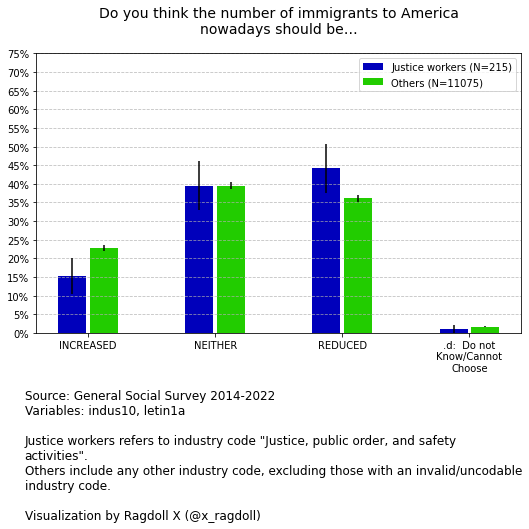

In [8]:
values = ['INCREASED', 'NEITHER', 'REDUCED', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['letin1a'].map(lambda x: x in values)]['letin1a']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper right')
ax.set_title(
    parse_string('Do you think the number of immigrants to America nowadays should be…', 50),
    y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s=parse_string(
        'Source: General Social Survey 2014-2022\nVariables: indus10, letin1a\n\n'+\
        'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
        'Others include any other industry code, excluding those with an invalid/uncodable industry code.\n\n'+\
        'Visualization by Ragdoll X (@x_ragdoll)',
        85
    ),
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig3.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [9]:
print(
    1 - stats.norm.cdf(two_proportions_z_test(33, 215, 2518, 11075)),
    stats.norm.cdf(two_proportions_z_test(95, 215, 3995, 11075))
)

0.005155638581345823 0.0071127527822095315


68 0.4  |  100 0.5882  |  2 0.0118  |  170
4148 0.4721  |  4419 0.5029  |  220 0.025  |  8787


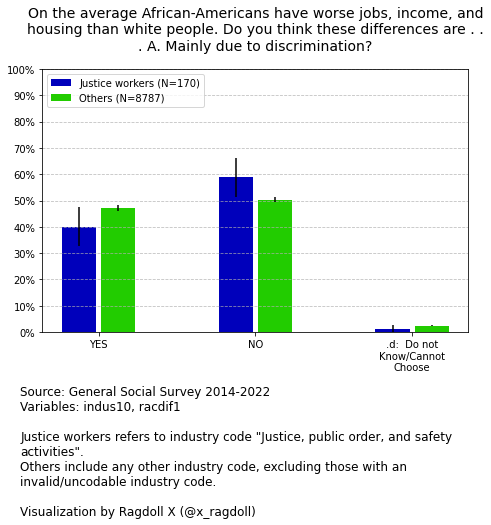

In [10]:
values = ['YES', 'NO', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(7, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['racdif1'].map(lambda x: x in values)]['racdif1']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, .1))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 101, 10)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string(
        'On the average African-Americans have worse jobs, income, and housing than white people. '+\
        'Do you think these differences are . . . A. Mainly due to discrimination?',
        65
    ), y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.2, va='top',
    s='Source: General Social Survey 2014-2022\nVariables: indus10, racdif1\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety\nactivities".\n'+\
      'Others include any other industry code, excluding those with an\ninvalid/uncodable industry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)',
    fontsize=12
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig4.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [11]:
print(
    1 - stats.norm.cdf(two_proportions_z_test(68, 170, 4148, 8787)),
    stats.norm.cdf(two_proportions_z_test(100, 170, 4419, 8787))
)

0.03113218374773108 0.013758944257681623


13 0.0765  |  157 0.9235  |  0 0.0  |  170
639 0.0726  |  8055 0.9147  |  112 0.0127  |  8806


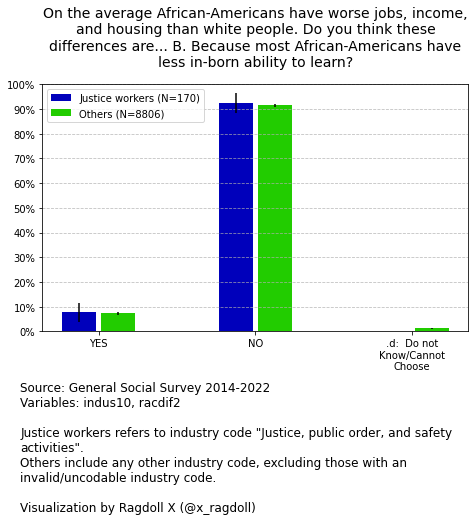

In [12]:
values = ['YES', 'NO', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(7, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['racdif2'].map(lambda x: x in values)]['racdif2']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, .1))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 101, 10)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string(
        'On the average African-Americans have worse jobs, income, and housing than white people. '+\
        'Do you think these differences are... B. Because most African-Americans have less in-born ability to learn?',
        60
    ), y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.2, va='top', fontsize=12,
    s='Source: General Social Survey 2014-2022\nVariables: indus10, racdif2\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety\nactivities".\n'+\
      'Others include any other industry code, excluding those with an\ninvalid/uncodable industry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig5.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

86 0.5089  |  81 0.4793  |  2 0.0118  |  169
4493 0.511  |  4143 0.4712  |  156 0.0177  |  8792


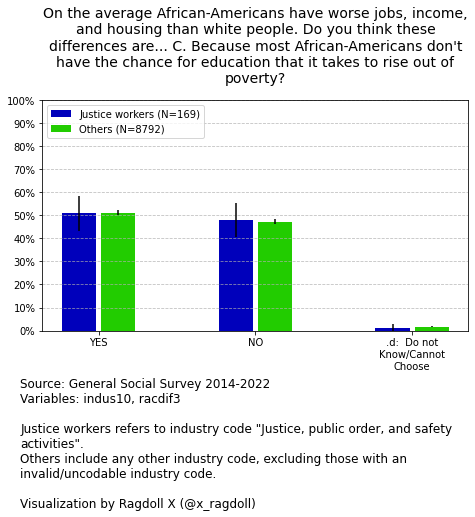

In [13]:
values = ['YES', 'NO', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(7, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['racdif3'].map(lambda x: x in values)]['racdif3']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, .1))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 101, 10)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string(
        'On the average African-Americans have worse jobs, income, and housing than white people. '+\
        'Do you think these differences are... C. Because most African-Americans don\'t have the '+\
        'chance for education that it takes to rise out of poverty?',
        60
    ), y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.2, va='top', fontsize=12,
    s='Source: General Social Survey 2014-2022\nVariables: indus10, racdif3\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety\nactivities".\n'+\
      'Others include any other industry code, excluding those with an\ninvalid/uncodable industry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig6.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

62 0.3647  |  105 0.6176  |  3 0.0176  |  170
3074 0.3507  |  5476 0.6247  |  216 0.0246  |  8766


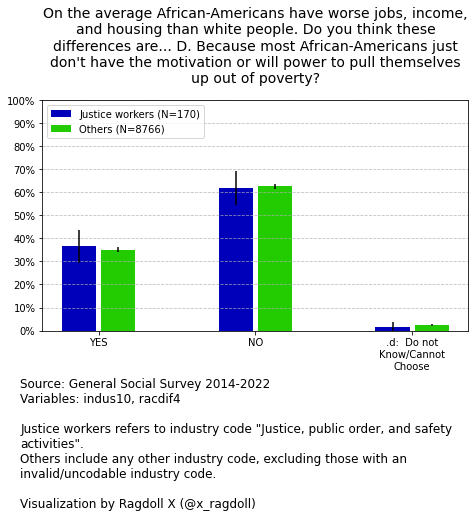

In [14]:
values = ['YES', 'NO', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(7, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['racdif4'].map(lambda x: x in values)]['racdif4']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, .1))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 101, 10)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string(
        'On the average African-Americans have worse jobs, income, and housing than white people. '+\
        'Do you think these differences are... D. Because most African-Americans just '+\
        'don\'t have the motivation or will power to pull themselves up out of poverty?',
        60
    ), y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.2, va='top', fontsize=12,
    s='Source: General Social Survey 2014-2022\nVariables: indus10, racdif4\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety\nactivities".\n'+\
      'Others include any other industry code, excluding those with an\ninvalid/uncodable industry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig7.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

60 0.3141  |  113 0.5916  |  16 0.0838  |  2 0.0105  |  191
3519 0.3546  |  5070 0.5108  |  1249 0.1258  |  87 0.0088  |  9925


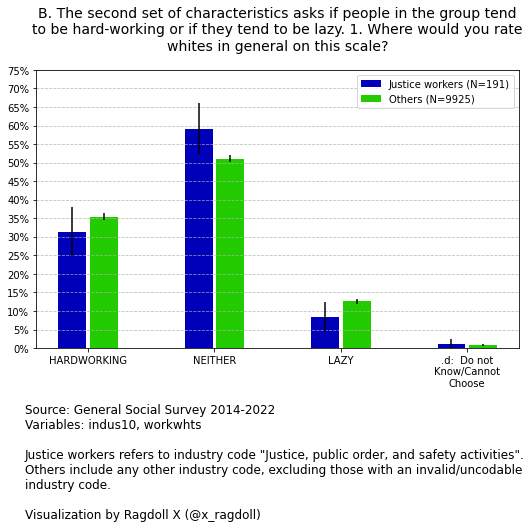

In [15]:
values = ['HARDWORKING', 'NEITHER', 'LAZY', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['workwhts'].map(lambda x: x in values)]['workwhts']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper right')
ax.set_title(
    parse_string(
        'B. The second set of characteristics asks if people in the group tend to be hard-working or if they tend to be lazy. '+\
        '1. Where would you rate whites in general on this scale?',
        70
    ), y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s='Source: General Social Survey 2014-2022\nVariables: indus10, workwhts\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable\nindustry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig8.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [16]:
# One-tailed Z-test.

p = np.array([
    stats.norm.cdf(two_proportions_z_test(60, 191, 3519 , 9925)),
    stats.norm.cdf(two_proportions_z_test(113, 191, 5070, 9925)),
    stats.norm.cdf(two_proportions_z_test(16, 191, 1249, 9925))
])

print(np.abs((p > .5) - p))

[0.12357513 0.01346181 0.04082002]


33 0.1728  |  112 0.5864  |  44 0.2304  |  2 0.0105  |  191
2661 0.269  |  4954 0.5008  |  2197 0.2221  |  81 0.0082  |  9893


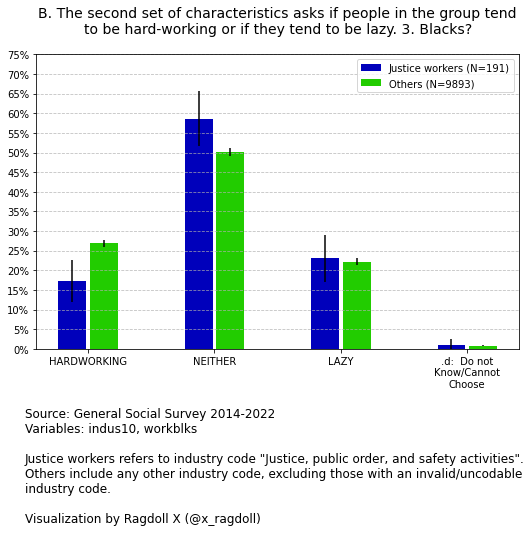

In [17]:
values = ['HARDWORKING', 'NEITHER', 'LAZY', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['workblks'].map(lambda x: x in values)]['workblks']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper right')
ax.set_title(
    parse_string(
        'B. The second set of characteristics asks if people in the group tend to be hard-working or if they tend to be lazy. 3. Blacks?',
        70
    ), y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s='Source: General Social Survey 2014-2022\nVariables: indus10, workblks\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable\nindustry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig9.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [18]:
# One-tailed Z-test.

p = np.array([
    stats.norm.cdf(two_proportions_z_test(33, 191, 2661 , 9893)),
    stats.norm.cdf(two_proportions_z_test(112, 191, 4954, 9893)),
    stats.norm.cdf(two_proportions_z_test(44, 191, 2197, 9893))
])

print(np.abs((p > .5) - p))

[0.00145911 0.00953024 0.39244075]


43 0.5375  |  33 0.4125  |  4 0.05  |  0 0.0  |  80
2337 0.5674  |  1461 0.3547  |  312 0.0757  |  9 0.0022  |  4119


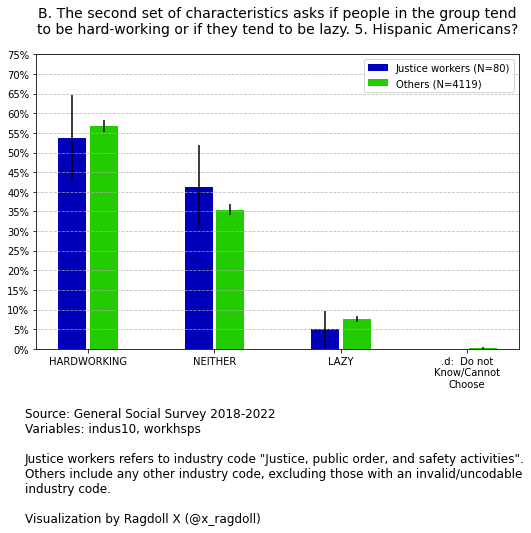

In [19]:
values = ['HARDWORKING', 'NEITHER', 'LAZY', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['workhsps'].map(lambda x: x in values)]['workhsps']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper right')
ax.set_title(
    parse_string(
        'B. The second set of characteristics asks if people in the group tend to be hard-working or if they tend to be lazy. 5. Hispanic Americans?',
        70
    ),
    y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s='Source: General Social Survey 2018-2022\nVariables: indus10, workhsps\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable\nindustry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig10.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [20]:
# One-tailed Z-test.

p = np.array([
    stats.norm.cdf(two_proportions_z_test(43, 80, 2337, 4119)),
    stats.norm.cdf(two_proportions_z_test(33, 80, 1461, 4119)),
    stats.norm.cdf(two_proportions_z_test(4, 80, 312, 4119))
])

print(np.abs((p > .5) - p))

[0.29666505 0.14241173 0.19363452]


64 0.3368  |  111 0.5842  |  12 0.0632  |  3 0.0158  |  190
4072 0.411  |  4845 0.489  |  881 0.0889  |  109 0.011  |  9907


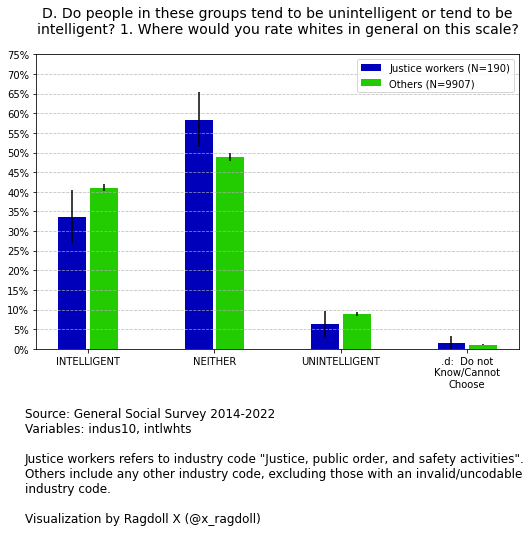

In [21]:
values = values = ['INTELLIGENT', 'NEITHER', 'UNINTELLIGENT', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['intlwhts'].map(lambda x: x in values)]['intlwhts']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper right')
ax.set_title(
    parse_string(
        'D. Do people in these groups tend to be unintelligent or tend to be intelligent? '+\
        '1. Where would you rate whites in general on this scale?',
        70
    ),
    y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s='Source: General Social Survey 2014-2022\nVariables: indus10, intlwhts\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable\nindustry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig11.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [22]:
# One-tailed Z-test.

p = np.array([
    stats.norm.cdf(two_proportions_z_test(64, 190, 4072, 9907)),
    stats.norm.cdf(two_proportions_z_test(111, 190, 4845, 9907)),
    stats.norm.cdf(two_proportions_z_test(12, 190, 881, 9907))
])

print(np.abs((p > .5) - p))

[0.01971827 0.00467368 0.10764189]


58 0.3053  |  108 0.5684  |  21 0.1105  |  3 0.0158  |  190
3273 0.3315  |  5450 0.552  |  1061 0.1075  |  89 0.009  |  9873


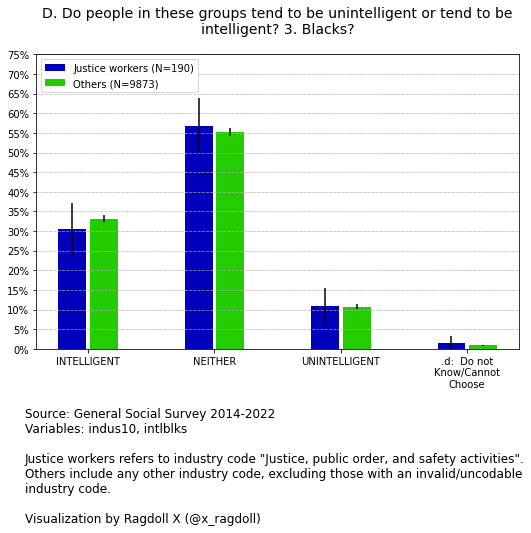

In [23]:
values = values = ['INTELLIGENT', 'NEITHER', 'UNINTELLIGENT', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['intlblks'].map(lambda x: x in values)]['intlblks']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string('D. Do people in these groups tend to be unintelligent or tend to be intelligent? 3. Blacks?', 70),
    y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s='Source: General Social Survey 2014-2022\nVariables: indus10, intlblks\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable\nindustry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig12.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [24]:
# One-tailed Z-test.

p = np.array([
    stats.norm.cdf(two_proportions_z_test(58, 190, 3273, 9907)),
    stats.norm.cdf(two_proportions_z_test(108, 190, 5450, 9907)),
    stats.norm.cdf(two_proportions_z_test(21, 190, 1061, 9907))
])

print(np.abs((p > .5) - p))

[0.23295055 0.30768326 0.4398223 ]


32 0.2759  |  76 0.6552  |  6 0.0517  |  2 0.0172  |  116
2097 0.3274  |  3595 0.5613  |  651 0.1016  |  62 0.0097  |  6405


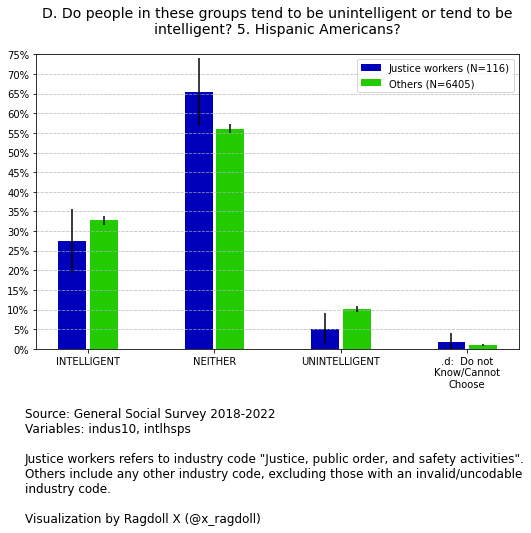

In [25]:
values = values = ['INTELLIGENT', 'NEITHER', 'UNINTELLIGENT', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['intlhsps'].map(lambda x: x in values)]['intlhsps']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper right')
ax.set_title(
    parse_string(
        'D. Do people in these groups tend to be unintelligent or tend to be intelligent? '+\
        '5. Hispanic Americans?',
        70
    ), y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s='Source: General Social Survey 2018-2022\nVariables: indus10, intlhsps\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable\nindustry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig13.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [26]:
# One-tailed Z-test.

p = np.array([
    stats.norm.cdf(two_proportions_z_test(32, 116, 2097, 6405)),
    stats.norm.cdf(two_proportions_z_test(76, 116, 3595, 6405)),
    stats.norm.cdf(two_proportions_z_test(6, 116, 651, 6405))
])

print(np.abs((p > .5) - p))

[0.12036564 0.02166541 0.03835488]


75 0.3886  |  107 0.5544  |  10 0.0518  |  1 0.0052  |  193
4376 0.4383  |  5268 0.5277  |  317 0.0318  |  22 0.0022  |  9983


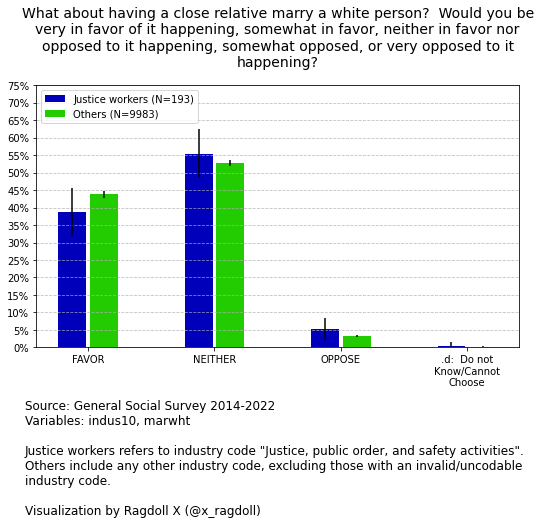

In [27]:
values = ['FAVOR', 'NEITHER', 'OPPOSE', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['marwht'].map(lambda x: x in values)]['marwht']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string(
        'What about having a close relative marry a white person?  Would you be very in favor of it happening, '+\
        'somewhat in favor, neither in favor nor opposed to it happening, somewhat opposed, or very opposed to it happening?',
        70
    ), y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s='Source: General Social Survey 2014-2022\nVariables: indus10, marwht\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable\nindustry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig14.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [28]:
# One-tailed Z-test.

p = np.array([
    stats.norm.cdf(two_proportions_z_test(75, 193, 4376, 9983)),
    stats.norm.cdf(two_proportions_z_test(107, 193, 5268, 9983)),
    stats.norm.cdf(two_proportions_z_test(10, 193, 317, 9983))
])

print(np.abs((p > .5) - p))

[0.08382065 0.23081846 0.05877737]


57 0.2969  |  116 0.6042  |  18 0.0938  |  1 0.0052  |  192
3412 0.3419  |  5541 0.5552  |  1003 0.1005  |  24 0.0024  |  9980


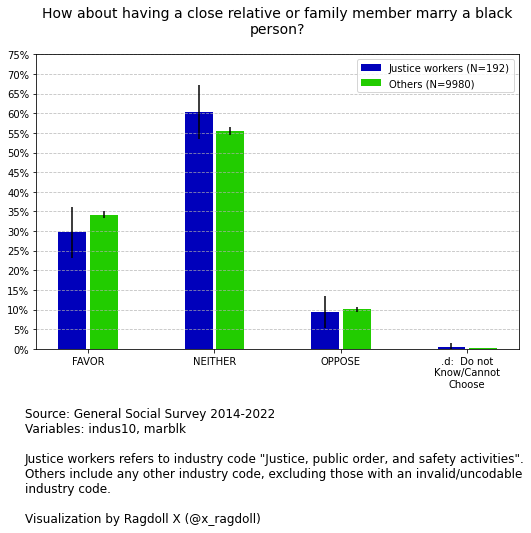

In [29]:
values = ['FAVOR', 'NEITHER', 'OPPOSE', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['marblk'].map(lambda x: x in values)]['marblk']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper right')
ax.set_title(
    parse_string('How about having a close relative or family member marry a black person?', 70),
    y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s='Source: General Social Survey 2014-2022\nVariables: indus10, marblk\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable\nindustry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig15.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [30]:
# One-tailed Z-test.

p = np.array([
    stats.norm.cdf(two_proportions_z_test(57, 192, 3412, 9980)),
    stats.norm.cdf(two_proportions_z_test(116, 192, 5541, 9980)),
    stats.norm.cdf(two_proportions_z_test(18, 192, 1003, 9980))
])

print(np.abs((p > .5) - p))

[0.09626945 0.08812368 0.37890904]


63 0.3281  |  123 0.6406  |  6 0.0312  |  0 0.0  |  192
3562 0.3574  |  5708 0.5727  |  663 0.0665  |  34 0.0034  |  9967


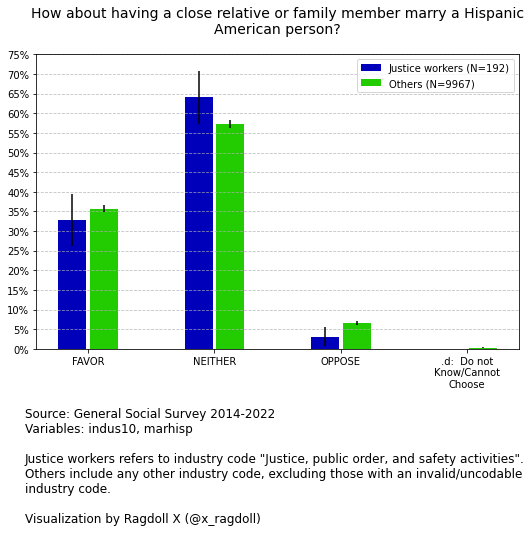

In [31]:
values = ['FAVOR', 'NEITHER', 'OPPOSE', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['marhisp'].map(lambda x: x in values)]['marhisp']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper right')
ax.set_title(
    parse_string('How about having a close relative or family member marry a Hispanic American person?', 70),
    y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s='Source: General Social Survey 2014-2022\nVariables: indus10, marhisp\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable\nindustry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig16.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [32]:
# One-tailed Z-test.

p = np.array([
    stats.norm.cdf(two_proportions_z_test(63, 192, 3562, 9967)),
    stats.norm.cdf(two_proportions_z_test(123, 192, 5708, 9967)),
    stats.norm.cdf(two_proportions_z_test(6, 192, 663, 9967))
])

print(np.abs((p > .5) - p))

[0.20098218 0.02967796 0.0254873 ]


35 0.1613  |  65 0.2995  |  16 0.0737  |  217
2151 0.1927  |  3207 0.2873  |  1443 0.1293  |  11161


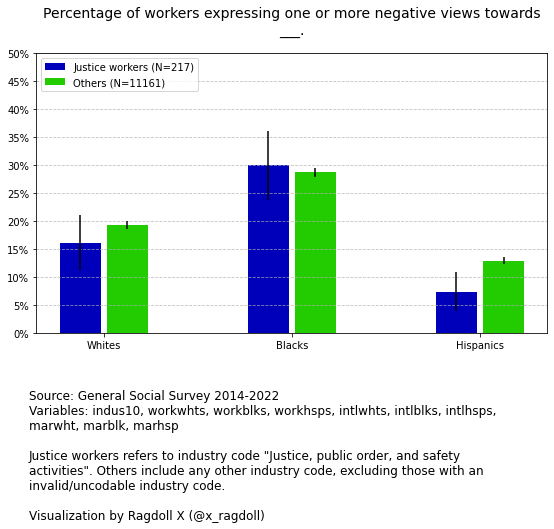

In [33]:
filter_columns = ['workwhts', 'workblks', 'workhsps', 'intlwhts', 'intlblks', 'intlhsps', 'marwht', 'marblk', 'marhisp']
invalid_values = ['.i:  Inapplicable', '.n:  No answer', '.s:  Skipped on Web']

legend_handles, totals = [], []
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for i in range(2):
    # Only include participants who answered at least one of the questions.
    data = df_other if i else df_justice
    data = data.loc[np.where([np.any([y not in invalid_values for y in x]) for x in data[filter_columns].values])]
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j in range(3):
        columns = [['workwhts', 'intlwhts', 'marwht'], ['workblks', 'intlblks', 'marblk'], ['workhsps', 'intlhsps', 'marhisp']][j]
        p = len(np.where((data[columns[0]] == 'LAZY') | (data[columns[1]] == 'UNINTELLIGENT') | (data[columns[2]] == 'OPPOSE'))[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, 2))
ax.set_xticklabels(['Whites', 'Blacks', 'Hispanics'])
ax.set_ylim(0, .5)
ax.set_yticks(np.arange(0, .51, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 51, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string('Percentage of workers expressing one or more negative views towards ___.', 70),
    y=1.05, fontsize=14
)
ax.text(
    x=-1.4, y=-.1, va='top', fontsize=12,
    s=parse_string(
        'Source: General Social Survey 2014-2022\nVariables: indus10, workwhts, workblks, workhsps, '+\
        'intlwhts, intlblks, intlhsps, marwht, marblk, marhsp\n\n'+\
        'Justice workers refers to industry code "Justice, public order, and safety activities". '+\
        'Others include any other industry code, excluding those with an invalid/uncodable industry code.\n\n'+\
        'Visualization by Ragdoll X (@x_ragdoll)', 80
    )
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig17.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [34]:
# One-tailed Z-test.

p = np.array([
    stats.norm.cdf(two_proportions_z_test(35, 217, 2151, 11161)),
    stats.norm.cdf(two_proportions_z_test(65, 217, 3207, 11161)),
    stats.norm.cdf(two_proportions_z_test(16, 217, 1443, 11161))
])

print('\t'*4 + 'Justice workers\t\tOther workers')
print('Negative views whites:\t\t', round(35/217, 3), '\t\t\t', round(2151/11161, 3))
print('Negative views blacks:\t\t', round(65/217, 3), '\t\t\t', round(3207/11161, 3))
print('Negative views hispanics:\t', round(16/217, 3), '\t\t\t', round(1443/11161, 3))
print()
print(np.abs((p > .5) - p))

				Justice workers		Other workers
Negative views whites:		 0.161 			 0.193
Negative views blacks:		 0.3 			 0.287
Negative views hispanics:	 0.074 			 0.129

[0.12219261 0.34707693 0.00766856]


35 0.1613  |  69 0.318  |  16 0.0737  |  217
2151 0.1927  |  3458 0.3098  |  1443 0.1293  |  11161


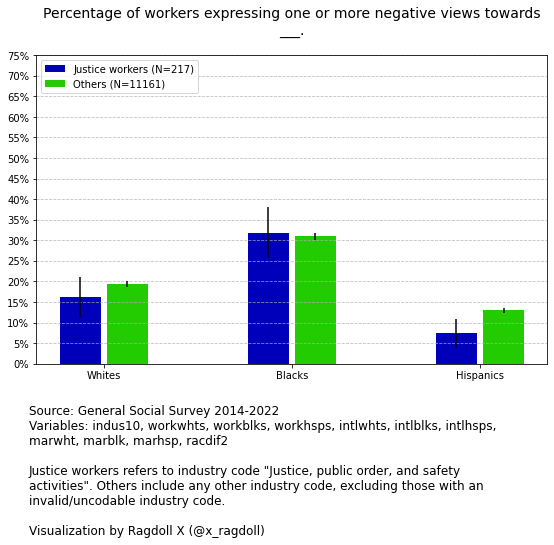

In [35]:
filter_columns = ['workwhts', 'workblks', 'workhsps', 'intlwhts', 'intlblks', 'intlhsps', 'marwht', 'marblk', 'marhisp']
invalid_values = ['.i:  Inapplicable', '.n:  No answer', '.s:  Skipped on Web']

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    # Only include participants who answered at least one of the questions.
    data = df_other if i else df_justice
    data = data.loc[np.where([np.any([y not in invalid_values for y in x]) for x in data[filter_columns].values])]
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j in range(3):
        if j == 0:
            p = len(np.where((data['workwhts'] == 'LAZY') | (data['intlwhts'] == 'UNINTELLIGENT') | (data['marwht'] == 'OPPOSE'))[0])
        elif j == 1:
            p = len(np.where((data['workblks'] == 'LAZY') | (data['intlblks'] == 'UNINTELLIGENT') | (data['marblk'] == 'OPPOSE') | (data['racdif2'] == 'YES'))[0])
        else:
            p = len(np.where((data['workhsps'] == 'LAZY') | (data['intlhsps'] == 'UNINTELLIGENT') | (data['marhisp'] == 'OPPOSE'))[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, 2))
ax.set_xticklabels(['Whites', 'Blacks', 'Hispanics'])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string('Percentage of workers expressing one or more negative views towards ___.', 70),
    y=1.05, fontsize=14
)
ax.text(
    x=-1.4, y=-.1, va='top', fontsize=12,
    s=parse_string(
        'Source: General Social Survey 2014-2022\nVariables: indus10, workwhts, workblks, workhsps, '+\
        'intlwhts, intlblks, intlhsps, marwht, marblk, marhsp, racdif2\n\n'+\
        'Justice workers refers to industry code "Justice, public order, and safety activities". '+\
        'Others include any other industry code, excluding those with an invalid/uncodable industry code.\n\n'+\
        'Visualization by Ragdoll X (@x_ragdoll)', 80
    )
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig18.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [64]:
# One-tailed Z-test.

p = np.array([
    stats.norm.cdf(two_proportions_z_test(35, 217, 2151, 11161)),
    stats.norm.cdf(two_proportions_z_test(69, 217, 3458, 11161)),
    stats.norm.cdf(two_proportions_z_test(16, 217, 1443, 11161))
])

print('\t'*4 + 'Justice workers\t\tOther workers')
print('Negative views whites:\t\t', round(35/217, 3), '\t\t\t', round(2151/11161, 3))
print('Negative views blacks:\t\t', round(69/217, 3), '\t\t\t', round(3458/11161, 3))
print('Negative views hispanics:\t', round(16/217, 3), '\t\t\t', round(1443/11161, 3))
print()
print(np.abs((p > .5) - p))

				Justice workers		Other workers
Negative views whites:		 0.161 			 0.193
Negative views blacks:		 0.318 			 0.31
Negative views hispanics:	 0.074 			 0.129

[0.12219261 0.39862908 0.00766856]


95 0.4378  |  73 0.3364  |  55 0.2535  |  217
5289 0.4739  |  4420 0.396  |  3464 0.3104  |  11161


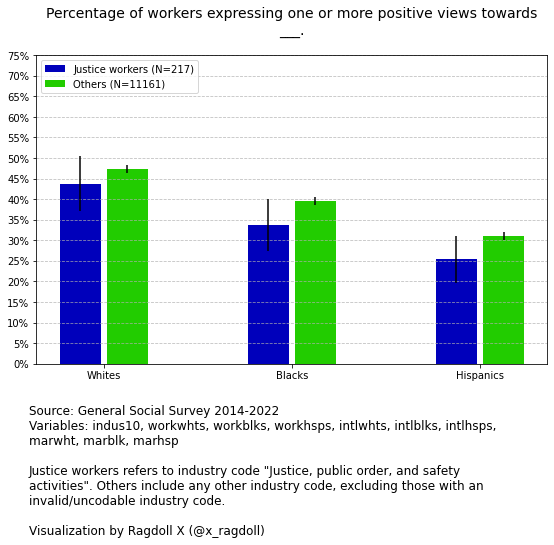

In [37]:
filter_columns = ['workwhts', 'workblks', 'workhsps', 'intlwhts', 'intlblks', 'intlhsps', 'marwht', 'marblk', 'marhisp']
invalid_values = ['.i:  Inapplicable', '.n:  No answer', '.s:  Skipped on Web']

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    # Only include participants who answered at least one of the questions.
    data = df_other if i else df_justice
    data = data.loc[np.where([np.any([y not in invalid_values for y in x]) for x in data[filter_columns].values])]
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j in range(3):
        columns = [['workwhts', 'intlwhts', 'marwht'], ['workblks', 'intlblks', 'marblk'], ['workhsps', 'intlhsps', 'marhisp']][j]
        p = len(np.where((data[columns[0]] == 'HARDWORKING') | (data[columns[1]] == 'INTELLIGENT') | (data[columns[2]] == 'SUPPORT'))[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, 2))
ax.set_xticklabels(['Whites', 'Blacks', 'Hispanics'])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string('Percentage of workers expressing one or more positive views towards ___.', 70),
    y=1.05, fontsize=14
)
ax.text(
    x=-1.4, y=-.1, va='top', fontsize=12,
    s=parse_string(
        'Source: General Social Survey 2014-2022\nVariables: indus10, workwhts, workblks, workhsps, '+\
        'intlwhts, intlblks, intlhsps, marwht, marblk, marhsp\n\n'+\
        'Justice workers refers to industry code "Justice, public order, and safety activities". '+\
        'Others include any other industry code, excluding those with an invalid/uncodable industry code.\n\n'+\
        'Visualization by Ragdoll X (@x_ragdoll)', 80
    )
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2014-2022/fig19.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [38]:
# One-tailed Z-test.

p = np.array([
    stats.norm.cdf(two_proportions_z_test(95, 217, 5289, 11161)),
    stats.norm.cdf(two_proportions_z_test(73, 217, 4420, 11161)),
    stats.norm.cdf(two_proportions_z_test(55, 217, 3464, 11161))
])

print('\t'*4 + 'Justice workers\t\tOther workers')
print('Positive views whites:\t\t', round(95/217, 3), '\t\t\t', round(5289/11161, 3))
print('Positive views blacks:\t\t', round(73/217, 3), '\t\t\t', round(4420/11161, 3))
print('Positive views hispanics:\t', round(55/217, 3), '\t\t\t', round(3464/11161, 3))
print()
print(np.abs((p > .5) - p))

				Justice workers		Other workers
Positive views whites:		 0.438 			 0.474
Positive views blacks:		 0.336 			 0.396
Positive views hispanics:	 0.253 			 0.31

[0.14577429 0.03759185 0.03621269]


---

### Load and visualize data for 2000-2012

In [39]:
df = pd.read_csv(expanduser('~') + '/Documents/Surveys/Justice workers/GSS justice workers 2000-2012.csv')
df['letin1a'] = df['letin1a'].map(
    lambda x: 'REDUCED' if x in ('Reduced a little', 'Reduced a lot') else\
              'NEITHER' if x == 'Remain the same as it is' else\
              'INCREASED' if x in ('Increased a little', 'Increased a lot') else x
)
df['workwhts'] = df['workwhts'].map(
    lambda x: 'HARDWORKING' if x in ('2', '3') else 'NEITHER' if x == '4' else 'LAZY' if x in ('5', '6') else x
)
df['workblks'] = df['workblks'].map(
    lambda x: 'HARDWORKING' if x in ('2', '3') else 'NEITHER' if x == '4' else 'LAZY' if x in ('5', '6') else x
)
df['intlwhts'] = df['intlwhts'].map(
    lambda x: 'UNINTELLIGENT' if x in ('2', '3') else 'NEITHER' if x == '4' else 'INTELLIGENT' if x in ('5', '6') else x
)
df['intlblks'] = df['intlblks'].map(
    lambda x: 'UNINTELLIGENT' if x in ('2', '3') else 'NEITHER' if x == '4' else 'INTELLIGENT' if x in ('5', '6') else x
)
df['marwht'] = df['marwht'].map(
    lambda x: 'NEITHER' if 'NEITHER' in x else 'FAVOR' if 'FAVOR' in x else 'OPPOSE' if 'OPPOSE' in x else x
)
df['marblk'] = df['marblk'].map(
    lambda x: 'NEITHER' if 'NEITHER' in x else 'FAVOR' if 'FAVOR' in x else 'OPPOSE' if 'OPPOSE' in x else x
)
df.tail()

,year,id_,indus10,polviews,racdif1,racdif2,racdif3,racdif4,workwhts,workblks,intlwhts,intlblks,marblk,marwht,letin1a,ballot
18940,2012,1970,Executive offices and legislative bodies,Liberal,NO,YES,NO,YES,HARDWORKING,LAZY,UNINTELLIGENT,INTELLIGENT,NEITHER,NEITHER,REDUCED,Ballot b
18941,2012,1971,Executive offices and legislative bodies,"Moderate, middle of the road",.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,Ballot c
18942,2012,1972,"Other amusement, gambling, and recreation indu...","Moderate, middle of the road",NO,NO,NO,YES,NEITHER,LAZY,INTELLIGENT,UNINTELLIGENT,NEITHER,NEITHER,REDUCED,Ballot a
18943,2012,1973,Child day care services,Slightly conservative,YES,NO,YES,NO,HARDWORKING,HARDWORKING,INTELLIGENT,INTELLIGENT,FAVOR,FAVOR,INCREASED,Ballot b
18944,2012,1974,.i: Inapplicable,"Moderate, middle of the road",.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,Ballot c


In [40]:
industries_justice = 'Justice, public order, and safety activities'
industries_invalid = ('.i: Inapplicable', '.n: No answer', '.s: Skipped on Web', '.u: Uncodable')

df_justice = df.loc[np.where([x == industries_justice for x in df['indus10']])]
df_justice.index = range(len(df_justice))
df_other = df.loc[np.where([x != industries_justice and x not in industries_invalid for x in df['indus10']])]
df_other.index = range(len(df_other))

df_justice.shape, df_other.shape

((336, 16), (18609, 16))

4 0.014 30 0.1053 26 0.0912 115 0.4035 48 0.1684 52 0.1825 10 0.0351 
561 0.0371 1808 0.1196 1749 0.1157 5840 0.3864 2184 0.1445 2411 0.1595 559 0.037 


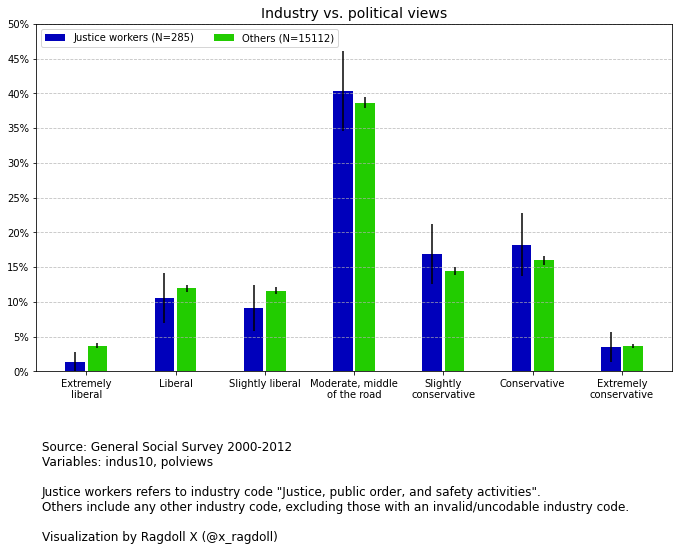

In [41]:
values = ('Extremely liberal', 'Liberal', 'Slightly liberal', 'Moderate, middle of the road', 'Slightly conservative', 'Conservative', 'Extremely conservative')
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['polviews'].map(lambda x: x in values)]['polviews']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        n = len(np.where(data == v)[0])
        me = margin_of_error_proportion(n, total)
        rect = ax.bar(i/4 + j - 1.125, n/total, width=.22, color=color, yerr=me)
        print(n, np.round(n/total, 4), end=' ')
    print()
    legend_handles.append(rect) # Only need the last one.
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .5)
ax.set_yticks(np.arange(0, .51, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 51, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=2, loc='upper left')
ax.set_title('Industry vs. political views', fontsize=14)
ax.text(
    x=-1.5, y=-.1, va='top', fontsize=12,
    s='Source: General Social Survey 2000-2012\nVariables: indus10, polviews\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable industry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2000-2012/fig1.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

[ 60 115 110] [0.2105 0.4035 0.386 ]
[4118 5840 5154] [0.2725 0.3864 0.3411]


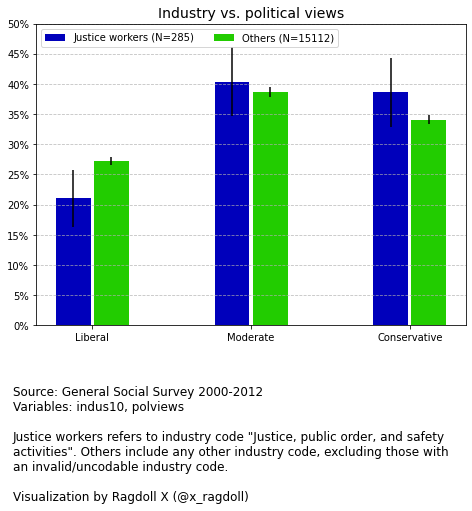

In [42]:
values = ('Extremely liberal', 'Liberal', 'Slightly liberal', 'Moderate, middle of the road', 'Slightly conservative', 'Conservative', 'Extremely conservative')
fig, ax = plt.subplots(1, 1, figsize=(7, 7.5))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['polviews'].map(lambda x: x in values)]['polviews']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    p = np.array([
        len(np.where([x in ('Extremely liberal', 'Liberal', 'Slightly liberal') for x in data])[0]),
        len(np.where([x in ('Moderate, middle of the road') for x in data])[0]),
        len(np.where([x in ('Extremely conservative', 'Conservative', 'Slightly conservative') for x in data])[0])
    ])
    print(p, np.round(p/total, 4))
    me = [margin_of_error_proportion(x, total) for x in p]
    rect = ax.bar(np.arange(-1, 2)+(-.12, .12)[i], p/total, width=.22, color=color, yerr=me)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, 2))
ax.set_xticklabels([parse_string(v, 16) for v in ('Liberal', 'Moderate', 'Conservative')])
ax.set_ylim(0, .5)
ax.set_yticks(np.arange(0, .51, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 51, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=2, loc='upper left')
ax.set_title('Industry vs. political views', fontsize=14)
ax.text(
    x=-1.5, y=-.1, va='top', fontsize=12,
    s=parse_string(
        'Source: General Social Survey 2000-2012\nVariables: indus10, polviews\n\n'+\
        'Justice workers refers to industry code "Justice, public order, and safety activities". '+\
        'Others include any other industry code, excluding those with an invalid/uncodable industry code.\n\n'+\
        'Visualization by Ragdoll X (@x_ragdoll)',
        75
    ),
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2000-2012/fig2.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [43]:
print(
    1 - stats.norm.cdf(two_proportions_z_test(60, 285, 4118, 15112)),
    stats.norm.cdf(two_proportions_z_test(110, 285, 5154, 15112))
)

0.009877255462229617 0.0566481870402067


6 0.0492  |  45 0.3689  |  69 0.5656  |  2 0.0164  |  122
849 0.1246  |  2404 0.3527  |  3411 0.5004  |  152 0.0223  |  6816


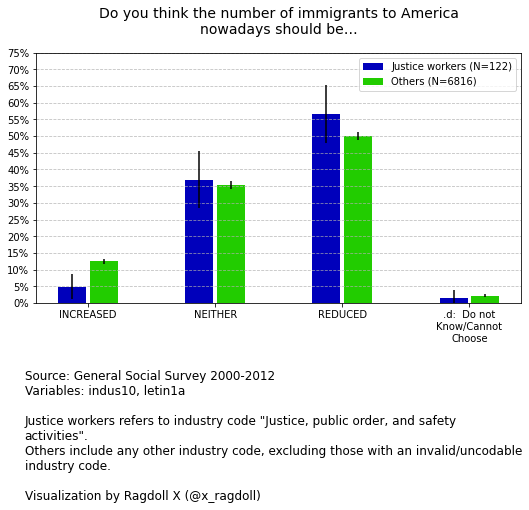

In [44]:
values = ['INCREASED', 'NEITHER', 'REDUCED', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['letin1a'].map(lambda x: x in values)]['letin1a']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper right')
ax.set_title(
    parse_string('Do you think the number of immigrants to America nowadays should be…', 50),
    y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.2, va='top', fontsize=12,
    s=parse_string(
        'Source: General Social Survey 2000-2012\nVariables: indus10, letin1a\n\n'+\
        'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
        'Others include any other industry code, excluding those with an invalid/uncodable industry code.\n\n'+\
        'Visualization by Ragdoll X (@x_ragdoll)',
        85
    ),
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2000-2012/fig3.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

In [45]:
print(
    1 - stats.norm.cdf(two_proportions_z_test(6, 122, 849, 6816)),
    stats.norm.cdf(two_proportions_z_test(69, 122, 3411, 6816))
)

0.0060267237782022365 0.07691261359148609


46 0.2706  |  119 0.7  |  5 0.0294  |  170
3369 0.3533  |  5748 0.6028  |  418 0.0438  |  9535


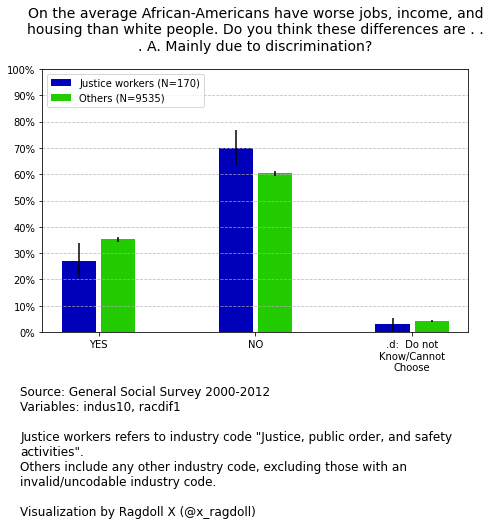

In [46]:
values = ['YES', 'NO', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(7, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['racdif1'].map(lambda x: x in values)]['racdif1']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, .1))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 101, 10)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string(
        'On the average African-Americans have worse jobs, income, and housing than white people. '+\
        'Do you think these differences are . . . A. Mainly due to discrimination?',
        65
    ), y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.2, va='top',
    s='Source: General Social Survey 2000-2012\nVariables: indus10, racdif1\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety\nactivities".\n'+\
      'Others include any other industry code, excluding those with an\ninvalid/uncodable industry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)',
    fontsize=12
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2000-2012/fig4.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

8 0.0468  |  159 0.9298  |  4 0.0234  |  171
987 0.1034  |  8310 0.8709  |  245 0.0257  |  9542


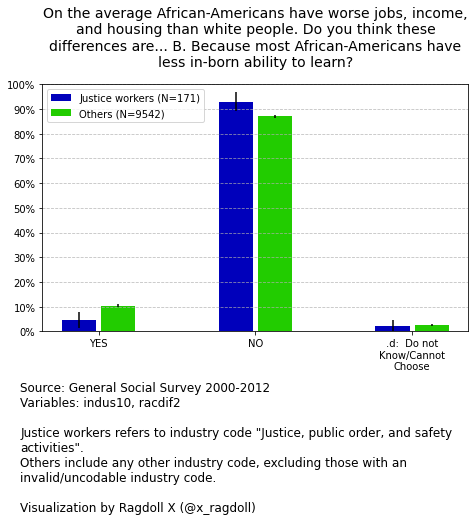

In [47]:
values = ['YES', 'NO', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(7, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['racdif2'].map(lambda x: x in values)]['racdif2']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, .1))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 101, 10)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string(
        'On the average African-Americans have worse jobs, income, and housing than white people. '+\
        'Do you think these differences are... B. Because most African-Americans have less in-born ability to learn?',
        60
    ), y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.2, va='top', fontsize=12,
    s='Source: General Social Survey 2000-2012\nVariables: indus10, racdif2\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety\nactivities".\n'+\
      'Others include any other industry code, excluding those with an\ninvalid/uncodable industry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2000-2012/fig5.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

63 0.3684  |  105 0.614  |  3 0.0175  |  171
4239 0.4442  |  5016 0.5257  |  287 0.0301  |  9542


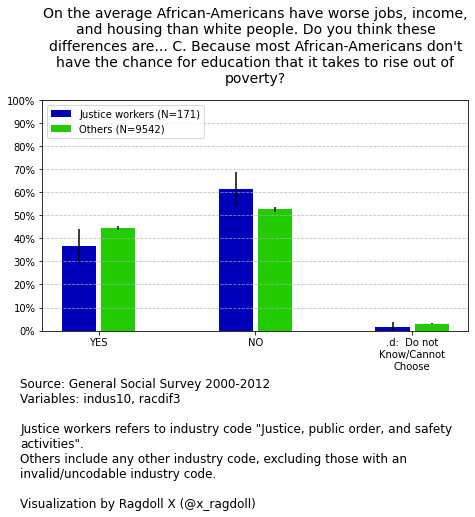

In [48]:
values = ['YES', 'NO', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(7, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['racdif3'].map(lambda x: x in values)]['racdif3']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, .1))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 101, 10)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string(
        'On the average African-Americans have worse jobs, income, and housing than white people. '+\
        'Do you think these differences are... C. Because most African-Americans don\'t have the '+\
        'chance for education that it takes to rise out of poverty?',
        60
    ), y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.2, va='top', fontsize=12,
    s='Source: General Social Survey 2000-2012\nVariables: indus10, racdif3\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety\nactivities".\n'+\
      'Others include any other industry code, excluding those with an\ninvalid/uncodable industry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2000-2012/fig6.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

81 0.4737  |  83 0.4854  |  7 0.0409  |  171
4484 0.4715  |  4551 0.4785  |  475 0.0499  |  9510


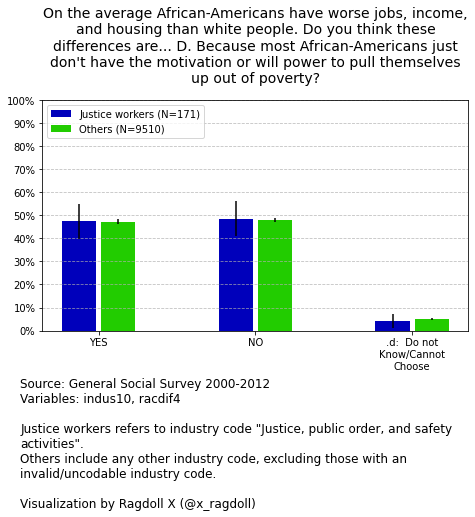

In [49]:
values = ['YES', 'NO', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(7, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['racdif4'].map(lambda x: x in values)]['racdif4']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, .1))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 101, 10)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string(
        'On the average African-Americans have worse jobs, income, and housing than white people. '+\
        'Do you think these differences are... D. Because most African-Americans just '+\
        'don\'t have the motivation or will power to pull themselves up out of poverty?',
        60
    ), y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.2, va='top', fontsize=12,
    s='Source: General Social Survey 2000-2012\nVariables: indus10, racdif4\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety\nactivities".\n'+\
      'Others include any other industry code, excluding those with an\ninvalid/uncodable industry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2000-2012/fig7.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

65 0.3714  |  89 0.5086  |  17 0.0971  |  4 0.0229  |  175
4021 0.4049  |  4513 0.4544  |  1161 0.1169  |  236 0.0238  |  9931


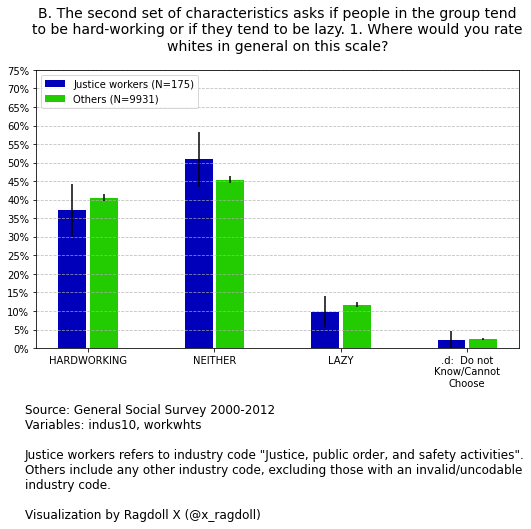

In [50]:
values = ['HARDWORKING', 'NEITHER', 'LAZY', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['workwhts'].map(lambda x: x in values)]['workwhts']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string(
        'B. The second set of characteristics asks if people in the group tend to be hard-working or if they tend to be lazy. '+\
        '1. Where would you rate whites in general on this scale?',
        70
    ), y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s='Source: General Social Survey 2000-2012\nVariables: indus10, workwhts\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable\nindustry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2000-2012/fig8.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

31 0.1782  |  92 0.5287  |  48 0.2759  |  3 0.0172  |  174
1953 0.1969  |  4521 0.4557  |  3171 0.3197  |  275 0.0277  |  9920


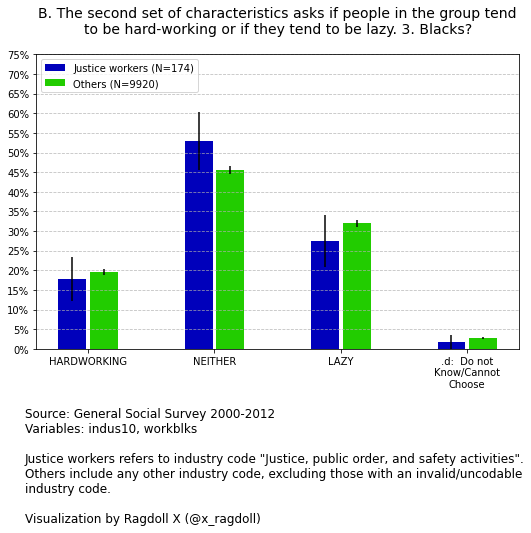

In [51]:
values = ['HARDWORKING', 'NEITHER', 'LAZY', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['workblks'].map(lambda x: x in values)]['workblks']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string(
        'B. The second set of characteristics asks if people in the group tend to be hard-working or if they tend to be lazy. 3. Blacks?',
        70
    ), y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s='Source: General Social Survey 2000-2012\nVariables: indus10, workblks\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable\nindustry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2000-2012/fig9.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

82 0.4633  |  79 0.4463  |  13 0.0734  |  3 0.0169  |  177
4528 0.4568  |  4321 0.4359  |  796 0.0803  |  267 0.0269  |  9912


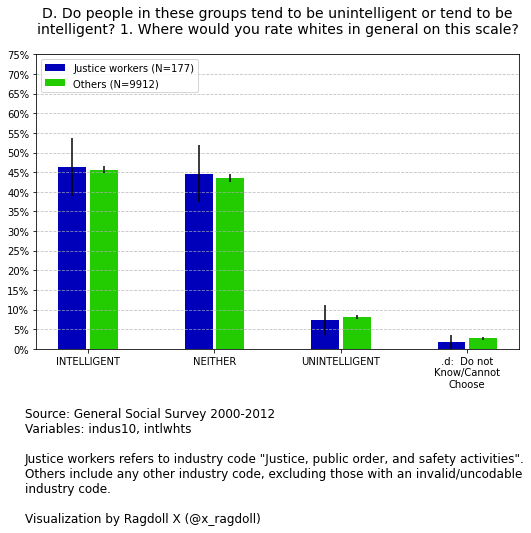

In [52]:
values = values = ['INTELLIGENT', 'NEITHER', 'UNINTELLIGENT', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['intlwhts'].map(lambda x: x in values)]['intlwhts']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string(
        'D. Do people in these groups tend to be unintelligent or tend to be intelligent? '+\
        '1. Where would you rate whites in general on this scale?',
        70
    ),
    y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s='Source: General Social Survey 2000-2012\nVariables: indus10, intlwhts\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable\nindustry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2000-2012/fig10.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

60 0.339  |  91 0.5141  |  23 0.1299  |  3 0.0169  |  177
2885 0.2911  |  5138 0.5185  |  1583 0.1597  |  304 0.0307  |  9910


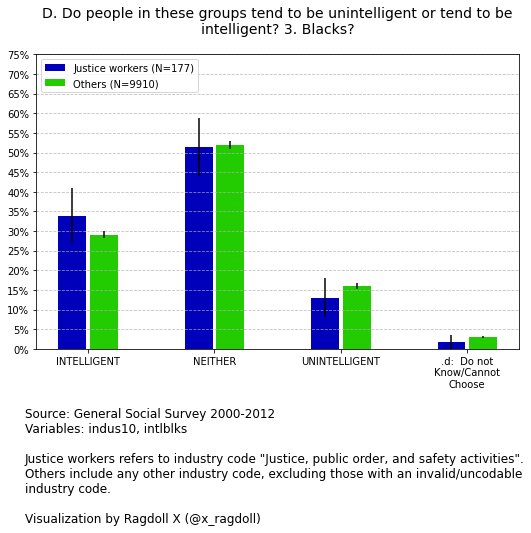

In [53]:
values = values = ['INTELLIGENT', 'NEITHER', 'UNINTELLIGENT', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['intlblks'].map(lambda x: x in values)]['intlblks']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string('D. Do people in these groups tend to be unintelligent or tend to be intelligent? 3. Blacks?', 70),
    y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s='Source: General Social Survey 2000-2012\nVariables: indus10, intlblks\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable\nindustry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2000-2012/fig11.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

91 0.5688  |  61 0.3812  |  7 0.0438  |  1 0.0062  |  160
5185 0.5759  |  3485 0.3871  |  294 0.0327  |  40 0.0044  |  9004


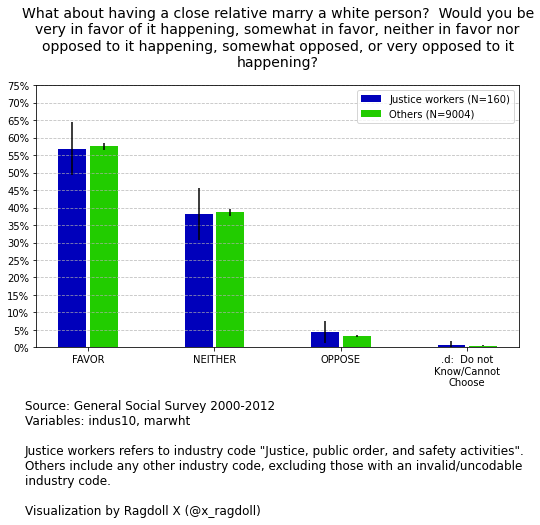

In [54]:
values = ['FAVOR', 'NEITHER', 'OPPOSE', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['marwht'].map(lambda x: x in values)]['marwht']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper right')
ax.set_title(
    parse_string(
        'What about having a close relative marry a white person?  Would you be very in favor of it happening, '+\
        'somewhat in favor, neither in favor nor opposed to it happening, somewhat opposed, or very opposed to it happening?',
        70
    ), y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s='Source: General Social Survey 2000-2012\nVariables: indus10, marwht\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable\nindustry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2000-2012/fig12.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

51 0.2881  |  75 0.4237  |  50 0.2825  |  1 0.0056  |  177
3077 0.3084  |  4445 0.4456  |  2390 0.2396  |  64 0.0064  |  9976


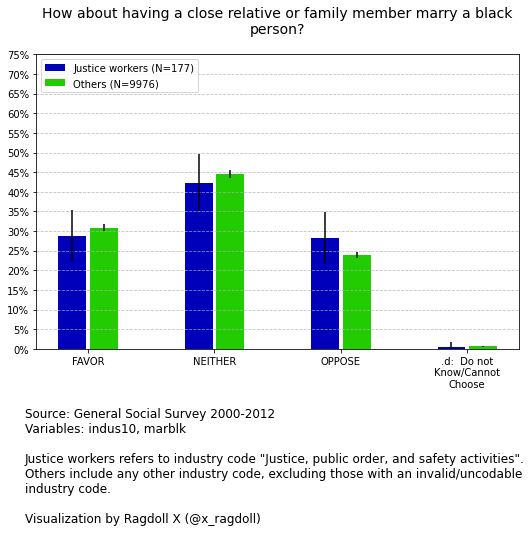

In [55]:
values = ['FAVOR', 'NEITHER', 'OPPOSE', '.d:  Do not Know/Cannot Choose']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

legend_handles, totals = [], []
for i in range(2):
    data = df_other if i else df_justice
    data = data.loc[data['marblk'].map(lambda x: x in values)]['marblk']
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j, v in enumerate(values):
        p = len(np.where(data == v)[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, len(values)-1))
ax.set_xticklabels([parse_string(v, 16) for v in values])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string('How about having a close relative or family member marry a black person?', 70),
    y=1.05, fontsize=14
)
ax.text(
    x=-1.5, y=-.15, va='top', fontsize=12,
    s='Source: General Social Survey 2000-2012\nVariables: indus10, marblk\n\n'+\
      'Justice workers refers to industry code "Justice, public order, and safety activities".\n'+\
      'Others include any other industry code, excluding those with an invalid/uncodable\nindustry code.\n\n'+\
      'Visualization by Ragdoll X (@x_ragdoll)'
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2000-2012/fig13.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

31 0.1751  |  89 0.5028  |  177
2029 0.2027  |  4846 0.4841  |  10010


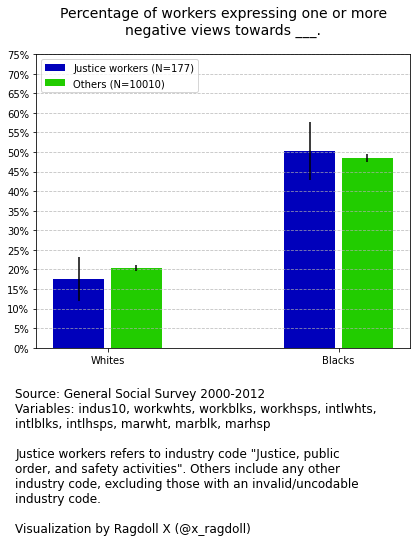

In [56]:
filter_columns = ['workwhts', 'workblks', 'intlwhts', 'intlblks', 'marwht', 'marblk']
invalid_values = ['.i:  Inapplicable', '.n:  No answer', '.s:  Skipped on Web']

legend_handles, totals = [], []
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
for i in range(2):
    # Only include participants who answered at least one of the questions.
    data = df_other if i else df_justice
    data = data.loc[np.where([np.any([y not in invalid_values for y in x]) for x in data[filter_columns].values])]
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j in range(2):
        columns = [['workwhts', 'intlwhts', 'marwht'], ['workblks', 'intlblks', 'marblk']][j]
        p = len(np.where((data[columns[0]] == 'LAZY') | (data[columns[1]] == 'UNINTELLIGENT') | (data[columns[2]] == 'OPPOSE'))[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, 1))
ax.set_xticklabels(['Whites', 'Blacks'])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string('Percentage of workers expressing one or more negative views towards ___.', 50),
    y=1.05, fontsize=14
)
ax.text(
    x=-1.4, y=-.1, va='top', fontsize=12,
    s=parse_string(
        'Source: General Social Survey 2000-2012\nVariables: indus10, workwhts, workblks, workhsps, '+\
        'intlwhts, intlblks, intlhsps, marwht, marblk, marhsp\n\n'+\
        'Justice workers refers to industry code "Justice, public order, and safety activities". '+\
        'Others include any other industry code, excluding those with an invalid/uncodable industry code.\n\n'+\
        'Visualization by Ragdoll X (@x_ragdoll)', 60
    )
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2000-2012/fig14.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)

97 0.548  |  69 0.3898  |  177
5870 0.5864  |  3818 0.3814  |  10010


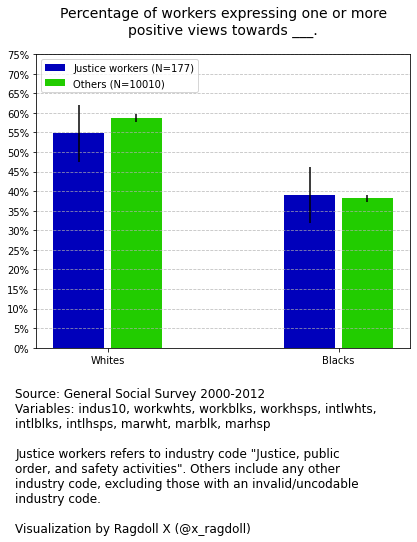

In [57]:
filter_columns = ['workwhts', 'workblks', 'intlwhts', 'intlblks', 'marwht', 'marblk']
invalid_values = ['.i:  Inapplicable', '.n:  No answer', '.s:  Skipped on Web']

fig, ax = plt.subplots(1, 1, figsize=(6, 8))

legend_handles, totals = [], []
for i in range(2):
    # Only include participants who answered at least one of the questions.
    data = df_other if i else df_justice
    data = data.loc[np.where([np.any([y not in invalid_values for y in x]) for x in data[filter_columns].values])]
    total = len(data)
    color = '#22cc00' if i else '#0000bb'
    for j in range(2):
        columns = [['workwhts', 'intlwhts', 'marwht'], ['workblks', 'intlblks', 'marblk']][j]
        p = len(np.where((data[columns[0]] == 'HARDWORKING') | (data[columns[1]] == 'INTELLIGENT') | (data[columns[2]] == 'SUPPORT'))[0])
        me = margin_of_error_proportion(p, total)
        rect = ax.bar(i/4 + j - 1.125, p/total, width=.22, color=color, yerr=me if p else None)
        print(p, np.round(p/total, 4), end='  |  ')
    print(total)
    legend_handles.append(rect)
    totals.append(total)

ax.set_xticks(range(-1, 1))
ax.set_xticklabels(['Whites', 'Blacks'])
ax.set_ylim(0, .75)
ax.set_yticks(np.arange(0, .76, .05))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 76, 5)])
ax.grid(axis='y', alpha=.8, linestyle='--')
ax.legend(legend_handles, ('Justice workers (N={})'.format(totals[0]), 'Others (N={})'.format(totals[1])), ncol=1, loc='upper left')
ax.set_title(
    parse_string('Percentage of workers expressing one or more positive views towards ___.', 50),
    y=1.05, fontsize=14
)
ax.text(
    x=-1.4, y=-.1, va='top', fontsize=12,
    s=parse_string(
        'Source: General Social Survey 2000-2012\nVariables: indus10, workwhts, workblks, workhsps, '+\
        'intlwhts, intlblks, intlhsps, marwht, marblk, marhsp\n\n'+\
        'Justice workers refers to industry code "Justice, public order, and safety activities". '+\
        'Others include any other industry code, excluding those with an invalid/uncodable industry code.\n\n'+\
        'Visualization by Ragdoll X (@x_ragdoll)', 60
    )
)

plt.tight_layout()
plt.show()
fig.savefig(
    expanduser('~')+'/Documents/Surveys/Justice workers/2000-2012/fig15.png',
    facecolor='w', edgecolor='w', transparent=False, dpi=80
)